# Data Preparation

## Upload the training and testing Datasets:

ISIC2019 dataset:
- import the ground truth csv file
- import the ISIC2019 data samples as in distribution
resource: https://challenge.isic-archive.com/data/

Fitzpatric17k dataset:
- import the fitz17k data samples as outlier and divide them into dark OOD sample (FST V-VI) and light OOD sample (FST I-IV)
resource: https://github.com/mattgroh/fitzpatrick17k

In [37]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
import shutil

from sklearn import model_selection
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import importlib
import matplotlib.pyplot as plt

import torchmetrics
import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
from sklearn.model_selection import KFold
from torch.utils.data import ConcatDataset




## 1.Import Datasets

#### 1.1 ISIC2019 Dataset

In [ ]:
# ISIC2019 dataset

groundtruth = pd.read_csv("...Path to Ground_truth.csv...")
groundtruth = groundtruth.set_index("image")
indist = list(groundtruth.index)
X_data = []
folder_dir = "..Path to ISIC data folder..."
images = Path(folder_dir).glob("*.jpg")
count = 0
for i in list(images)[:10000]:
    image = Image.open(i).convert("RGB")
    img_resize = np.array(image.resize((32, 32), Image.Resampling.LANCZOS)).ravel()
    if i.stem in indist:
        X_data.append(img_resize)
        count += 1


#### 1.2 FitzPatrick17K Dataset

In [7]:
#Fitz17k dataset

ood_FST_V_VI = []  #Dark OOD
ood_FST_I_IV = []  #Light_OOD
ood_data = []      #ALL OOD

FST_V_VI_dir = "..Path to the folder"   #Dark images  
FST_I_IV_dir = "..Path to the folder"   #Light images
ALL_dir = "..Path to the folder"        #All the images


FST_V_VI_images = Path(FST_V_VI_dir).glob("*.jpg")
for i in FST_V_VI_images:
    image = Image.open(i).convert("RGB")
    img_resize = np.array(image.resize((32, 32), Image.Resampling.LANCZOS)).ravel()
    #### 1.2 FitzPatrick17K Dataset.append(img_resize)
    ood_data.append(img_resize)


FST_I_IV_images = Path(FST_I_IV_dir).glob("*.jpg")
for i in list(FST_I_IV_images)[:3300]:
    image = Image.open(i).convert("RGB")
    img_resize = np.array(image.resize((32, 32), Image.Resampling.LANCZOS)).ravel()
    ood_FST_I_IV.append(img_resize)
    ood_data.append(img_resize)

#### 1.3 Data Labeling

In [9]:
ood_data = np.array(ood_data)
ood_FST_I_IV= np.array(ood_FST_I_IV)
ood_FST_V_VI = np.array(ood_FST_V_VI)

X_array = np.array(X_data)
ood_array = np.array(ood_data)  #for all
ood_D_array = np.array(ood_darker) #for darker only
ood_L_array = np.array(ood_lighter) #for lighter only

Label the data sets for each skin tone category 

In [ ]:
#FST I-IV category
y_ind = np.zeros(X_array.shape[0])  # Inlier 
y_ood= np.ones(ood_L_array.shape[0]) # OutLier 

X = np.concatenate([X_array, ood_L_array ])
y = np.concatenate([y_ind, y_ood])
print(X.shape, y.shape)

(13300, 3072) (13300,)


In [ ]:
#FST V-VI Category

y_ind = np.zeros(X_array.shape[0]) 
y_ood= np.ones(ood_D_array.shape[0]) 

X = np.concatenate([X_array, ood_D_array ])
y = np.concatenate([y_ind, y_ood])
print(X.shape, y.shape)

(11318, 3072) (11318,)


In [ ]:
#ALL

y_ind = np.zeros(X_array.shape[0])   
y_ood= np.ones(ood_array.shape[0]) 

X = np.concatenate([X_array, ood_array ])
y = np.concatenate([y_ind, y_ood])
print(X.shape, y.shape)

(14618, 3072) (14618,)


## 2. PCA Visualization

Multi-Labeling for PCA visualization

In [13]:
y_ind = np.zeros(X_array.shape[0])  #Inlier
y_ood= np.ones(ood_array.shape[0]) *1 # OOD sample
y_ood_D = np.ones(ood_D_array.shape[0]) * 2  # OOD sample FST V-VI
y_ood_L = np.ones(ood_L_array.shape[0]) * 3  # OOD sample FST I-IV
X = np.concatenate([X_array, ood_D_array, ood_L_array])
y = np.concatenate([y_ind, y_ood_D, y_ood_L])
print(X.shape, y.shape)

(14618, 3072) (14618,)


explained variance ratio (first two components): [0.44557194 0.12567861]


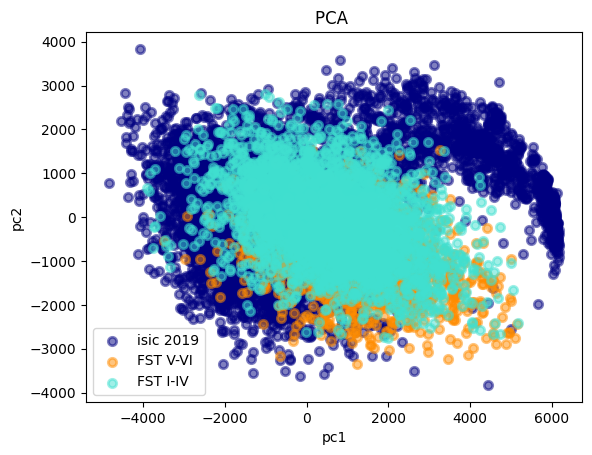

In [24]:
from sklearn.decomposition import PCA
import aux


importlib.reload(aux)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)

aux.plot_pca(X_pca, y)

plt.show()

## 3.Data Loaders

In [42]:
from torchvision import transforms as tfs

transforms_train = [
    tfs.RandomHorizontalFlip(p=0.5),
    # tfs.RandomAutocontrast(p=0.5),
    # tfs.RandomAdjustSharpness(p=0.5, sharpness_factor=0.7),
    tfs.RandomAffine(0, scale=(0.7, 1.0)),
    tfs.Resize((16, 16)),
    # tfs.Grayscale(1),
    tfs.ToTensor(),
    # tfs.Normalize(mean=0.46 ,std=0.32)
]

transforms_test = [
    tfs.Resize((16, 16)),
    # tfs.Grayscale(1),
    tfs.ToTensor(),
    # tfs.Normalize(mean=0.46 ,std=0.32)
]

The black module is not an IPython extension.


UsageError: Line magic function `%%black` not found.


Splitting the train dataset into training set (80%) and validation set (20%)

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

train_data_path = ""
image_data_train = ImageFolder(train_data_path, transform=tfs.Compose(transforms_train))
total_size = len(image_data_train)
train_size = int(0.8 * total_size)  # 80% for training
valid_size = total_size - train_size


train_dataset, valid_dataset = random_split(image_data_train, [train_size, valid_size])

In [ ]:

#ALL
image_data_test_ALL = ImageFolder( "path_to the folder", transform=tfs.Compose(transforms_test))

#FST V-VI 
image_data_test_darker = ImageFolder( "path to the folder", transform=tfs.Compose(transforms_test))

#FST I-IV
image_data_test_lighter = ImageFolder("path to the folder", transform=tfs.Compose(transforms_test))



In [ ]:
#FitzPatrick17K data loader as Out of distribution
data_loader_test_ALL = DataLoader(image_data_test_ALL, batch_size=100, shuffle=True) 
data_loader_test_Darker = DataLoader(image_data_test_darker, batch_size=100, shuffle=True)
data_loader_test_Lighter = DataLoader(image_data_test_lighter , batch_size=100 , shuffle=True ) 

In [ ]:
# ISIC data loader as in distribution
batch_size = 100
data_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
data_loader_validation = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)




---



---



## 4. RG Evaluation 

## 4.1 One Class SVM

Load the OneSVM pickle file and split the train dataset into train and test sets

In [25]:
from sklearn.svm import OneClassSVM
import pickle

with open('One_SVM_model.pkl', 'rb') as file:
    onesvm = pickle.load(file)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.4, stratify=y, random_state=42)

In [ ]:
y_test[y_test == 1] = -1
y_test[y_test == 0] = 1
y_test

array([ 1., -1.,  1., ..., -1., -1.,  1.])

## 4.1.1 Performance metrics calculation

Calculate the F1-score and roc-auc-score for each skin tone category and extact the Representation Gap between FST V-VI and FST I-IV scores

### FST I-IV

In [ ]:
#auc
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score

# Define a custom scoring function for ROC AUC
roc_auc_scorer = make_scorer(roc_auc_score)

# Perform cross-validation with ROC AUC scoring
auc_scores_all = cross_val_score(onesvm, X_test, y_test, cv=5, scoring=roc_auc_scorer)
print("auc scores light:", auc_scores_all)
print("Mean auc score light:", auc_scores_all.mean())
print("Standard deviation of auc scores light:", auc_scores_all.std())


auc scores light: [0.50931337 0.49562582 0.51743269 0.5276257  0.50112787]
Mean auc score light: 0.5102250933157141
Standard deviation of auc scores light: 0.011414553365299595


In [ ]:
#f1 score
f1_scores1 = cross_val_score(onesvm, X_test, y_test, cv=5, scoring='f1')
print("F1 scores:", f1_scores1)
print("Mean F1 score:", f1_scores1.mean())
print("Standard deviation of F1 scores:", f1_scores1.std())

F1 scores: [0.65335235 0.68975069 0.66855524 0.68508287 0.68927336]
Mean F1 score: 0.6772029032847702
Standard deviation of F1 scores: 0.014204700299303792


### FST V-VI 

In [ ]:
#auc

roc_auc_scorer = make_scorer(roc_auc_score)
auc_scores_all = cross_val_score(onesvm, X_test, y_test, cv=5, scoring=roc_auc_scorer)

print("auc scores dark:", auc_scores_all)
print("Mean auc score dark:", auc_scores_all.mean())
print("Standard deviation of auc scores dark:", auc_scores_all.std())


auc scores dark: [0.54009301 0.60359965 0.52022417 0.51873258 0.51623073]
Mean auc score dark: 0.5397760272703749
Standard deviation of auc scores dark: 0.03302434876420588


In [ ]:
#F1 score
f1_scores1 = cross_val_score(onesvm, X_test, y_test, cv=5, scoring='f1')
print("F1 scores:", f1_scores1)
print("Mean F1 score:", f1_scores1.mean())
print("Standard deviation of F1 scores:", f1_scores1.std())

F1 scores: [0.7267312  0.71981777 0.71982116 0.69465649 0.68659004]
Mean F1 score: 0.7095233311540607
Standard deviation of F1 scores: 0.015843550049450913


### ALL

In [ ]:
#auc
roc_auc_scorer = make_scorer(roc_auc_score)
auc_scores_all = cross_val_score(onesvm, X_test, y_test, cv=5, scoring=roc_auc_scorer)

print("auc scores all:", auc_scores_all)
print("Mean auc score all:", auc_scores_all.mean())
print("Standard deviation of auc scores all:", auc_scores_all.std())


auc scores all: [0.50931337 0.49562582 0.51743269 0.5276257  0.50112787]
Mean auc score all: 0.5102250933157141
Standard deviation of auc scores all: 0.011414553365299595


In [ ]:
#F1 score
f1_scores1 = cross_val_score(onesvm, X_test, y_test, cv=5, scoring='f1')

print("F1 scores:", f1_scores1)
print("Mean F1 score:", f1_scores1.mean())
print("Standard deviation of F1 scores:", f1_scores1.std())

F1 scores: [0.63364993 0.63846662 0.62962963 0.64621677 0.65231572]
Mean F1 score: 0.6400557348232299
Standard deviation of F1 scores: 0.00825262203677053


## 4.1.2 Histograms

Plot the abnormal scores destributions satrified b skin tones 

In [26]:
Calculate the F1-score and roc-auc-score for each skin tone category and extact the Representation Gap between FST V-VI and FST I-IV scoresanomaly_scores_inliers = onesvm.score_samples(X_test[y_test== 0])
anomaly_scores_darker = onesvm.score_samples(X_test[y_test== 2])
anomaly_scores_lighter= onesvm.score_samples(X_test[y_test == 3])

print("Number of inliers samples:", np.sum(y_test == 0))
print("Number of darker outliers samples:", np.sum(y_test == 2))
print("Number of lighter outliers samples:", np.sum(y_test == 3))

Number of inliers samples: 4001
Number of darker outliers samples: 527
Number of lighter outliers samples: 1320


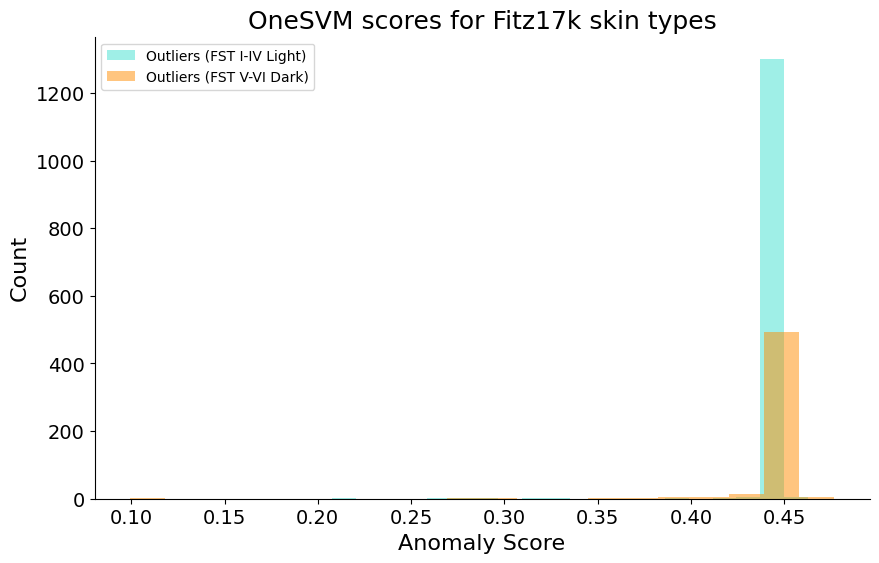

In [28]:
from aux_vis import plot_Histogram

plot_Histogram(anomaly_scores_lighter,anomaly_scores_darker,'OneSVM scores for Fitz17k skin types','Anomaly Score','Count')



---



---



## 4.2 Isolation Forest

Load the Isolation Forest pickle file 

In [ ]:
# Load the model Load the OneSVM pickle file and split the train dataset into train and test setsfrom the file
with open('isolation_forest_model.pkl', 'rb') as file:
    best_clf = pickle.load(file)

## 4.2.1 Performance metrics calculation

Calculate the F1-score and roc-auc-score for each skin tone category and extact the Representation Gap between FST V-VI and FST I-IV scores

### All

auc:

In [ ]:
#auc calculationF1 score:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score

# Define a custom scoring function for ROC AUC
roc_auc_scorer = make_scorer(roc_auc_score)

# Perform cross-validation with ROC AUC scoring
auc_scores_all = cross_val_score(best_clf, X_test, y_test, cv=5, scoring=roc_auc_scorer)
print("auc scores all:", auc_scores_all)
print("Mean auc score all:", auc_scores_all.mean())
print("Standard deviation of auc scores all:", auc_scores_all.std())

auc scores all: [0.50931337 0.52837945 0.51348128 0.540607   0.53968405]
Mean auc score all: 0.5262930324023477
Standard deviation of auc scores all: 0.0129692868633459


In [ ]:
y_test[y_test == 1] = -1
y_test[y_test == 0] = 1
y_test

array([ 1., -1.,  1., ..., -1., -1.,  1.])

F1 score:

In [ ]:
f1_scores1 = cross_val_score(best_clf, X_test, y_test, cv=5, scoring='f1')
print("F1 scores:", f1_scores1)
print("Mean F1 score:", f1_scores1.mean())
print("Standard deviation of F1 scores:", f1_scores1.std())

F1 scores: [0.76848354 0.76989247 0.77498664 0.73318633 0.76584318]
Mean F1 score: 0.7624784318834912
Standard deviation of F1 scores: 0.014945456839712332


### FST V-VI

auc:

In [ ]:

auc_scores_darker = cross_val_score(best_clf, X_test, y_test, cv=5, scoring=roc_auc_scorer)

print("auc scores darker:", auc_scores_darker)
print("Mean auc score darker:", auc_scores_darker.mean())
print("Standard deviation of auc scores darker:", auc_scores_darker.std())

auc scores darker: [0.47346126 0.47801434 0.49056669 0.44948821 0.47609108]
Mean auc score darker: 0.4735243159745933
Standard deviation of auc scores darker: 0.013378563385241177


F1 score:

In [ ]:
y_test[y_test == 1] = -1
y_test[y_test == 0] = 1
y_test

array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
f1_scores_darker = cross_val_score(best_clf, X_test, y_test, cv=5, scoring='f1')
print("F1 scores darker:", f1_scores_darker)
print("Mean F1 score darker:", f1_scores_darker.mean())
print("Standard deviation of F1 scores darker:", f1_scores_darker.std())

F1 scores darker: [0.8915212  0.89944479 0.89068323 0.89912827 0.90135635]
Mean F1 score darker: 0.8964267666331601
Standard deviation of F1 scores darker: 0.004421768548569421


### FST I-IV

auc:

In [ ]:

auc_scores_lighter = cross_val_score(best_clf, X_test, y_test, cv=5, scoring=roc_auc_scorer)

print("auc scores lighter:", auc_scores_lighter)
print("Mean auc score lighter:", auc_scores_lighter.mean())
print("Standard deviation of auc scores lighter:", auc_scores_lighter.std())

auc scores lighter: [0.53125    0.52981061 0.5305092  0.52122134 0.52230987]
Mean auc score lighter: 0.5270202030607065
Standard deviation of auc scores lighter: 0.004328156370330682


F1 score:

In [ ]:
y_test[y_test == 1] = -1
y_test[y_test == 0] = 1
y_test

array([ 1., -1.,  1., ...,  1.,  1.,  1.])

In [ ]:
f1_scores_lighter = cross_val_score(best_clf, X_test, y_test, cv=5, scoring='f1')
print("F1 scores lighter:", f1_scores_lighter)
print("Mean F1 score lighter:", f1_scores_lighter.mean())
print("Standard deviation of F1 scores lighter:", f1_scores_lighter.std())

F1 scores lighter: [0.80182232 0.80519481 0.7954023  0.80433542 0.81179138]
Mean F1 score lighter: 0.8037092471426975
Standard deviation of F1 scores lighter: 0.005300674973846504


## 4.2.2 Histograms

Plot the abnormal scores destributions satrified by skin tones For the IF model

In [ ]:
Plot the abnormal scores destributions satrified b skin tones anomaly_scores_inliers = best_clf.score_samples(X_test[y_test== 0])
anomaly_scores_darker = best_clf.score_samples(X_test[y_test== 2])
anomaly_scores_lighter= best_clf.score_samples(X_test[y_test == 3])

print("Number of inliers samples:", np.sum(y_test == 0))
print("Number of darker outliers samples:", np.sum(y_test == 2))
print("Number of lighter outliers samples:", np.sum(y_test == 3))

Number of inliers samples: 4001
Number of darker outliers samples: 527
Number of lighter outliers samples: 1320


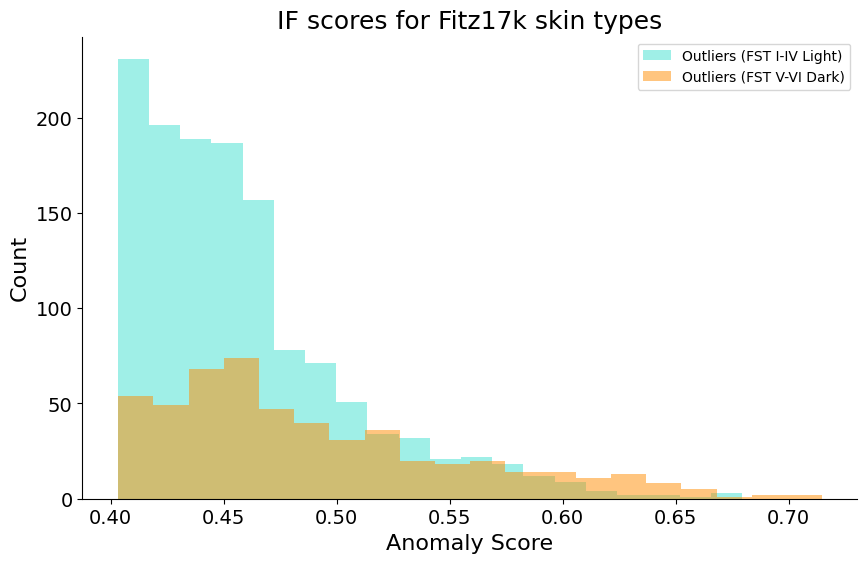

In [ ]:
from aux_vis import plot_Histogram

plot_Histogram(anomaly_scores_lighter,anomaly_scores_darker,'IF scores for Fitz17k skin types','Anomaly Score','Count')



---



## 4.3 AutoEncoder

In [32]:
from ae.py import Autoencoder
from torchsummary import summary


Load the saved weights pickle file of the AutoEncoder 

In [33]:
ae = Autoencoder()
ae.load_state_dict(torch.load("/content/autoencoder.pkl", map_location="cpu"))

<All keys matched successfully>

load the reconstruction error_df

In [ ]:
error_df = pd.read_csv('error_df.csv')
error_df

,re,labels
0,4.342609,0
1,4.265398,0
2,4.080728,0
3,24.960615,2
4,10.046871,0
...,...,...
32481,44.714958,1
32482,2.297856,0
32483,2.614737,0
32484,4.884062,0


Find the Threshold vales of FST V-VI and FST I-IV categories

In [ ]:
from scipy.stats import gaussian_kde

x = np.arange(0, 100)
t = gaussian_kde(error_df.re[error_df.labels == 0].values)
#e = gaussian_kde(error_df.re[error_df.labels == 0].values)
f = gaussian_kde(error_df.re[error_df.labels == 2].values)
g = gaussian_kde(error_df.re[error_df.labels == 1].values)
idxs_L = np.argwhere(np.diff(np.sign(t(x) - g(x)))).flatten() #FST I-IV
idxs_D = np.argwhere(np.diff(np.sign(t(x) - f(x)))).flatten() #FST V-VI


In [ ]:
print(idxs_L,idxs_D)

[7] [8]


In [ ]:
threshold_fixed_L = idxs_L
threshold_fixed_D = idxs_D

def apply_threshold(x):
    if (x <= threshold_fixed_L) & (x <= threshold_fixed_D):
        return 0
    else:
        return 1



error_df['output'] = error_df['re'].apply(apply_threshold)
error_df

,re,labels,output
0,4.342609,0,0
1,4.265398,0,0
2,4.080728,0,0
3,24.960615,2,1
4,10.046871,0,1
...,...,...,...
32481,44.714958,1,1
32482,2.297856,0,0
32483,2.614737,0,0
32484,4.884062,0,0


### 4.3.1 Histograms

Plot the abnormal scores destributions satrified by skin tones For the Ae model

In [ ]:
re_Lighter = error_df[(error_df['labels'] == 1) & (error_df['output'] == 1)]['re']
re_Darker = error_df[(error_df['labels'] == 2) & (error_df['output'] == 1)]['re']
re_Inlier = error_df[(error_df['labels'] == 0) & (error_df['output'] == 0)]['re']

# Print counts
print("Count of lighter:", len(re_Lighter))Plot the abnormal scores destributions satrified by skin tones For the IF model
print("Count of darker:", len(re_Darker))
print("Count of inlier:", len(re_Inlier))

Count of lighter: 9974
Count of darker: 1296
Count of inlier: 16935


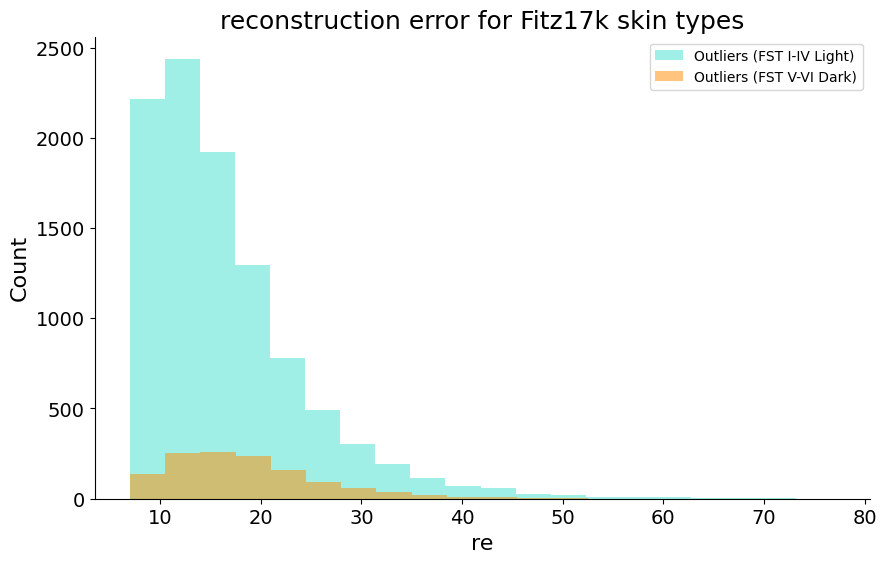

In [ ]:
from aux_vis import plot_Histogram

plot_Histogram(re_Lighter,re_Darker,'reconstruction error for Fitz17k skin types','re','Count')

### 4.3.2 Performance metrics calculation

In [ ]:
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.model_selection import KFold
from aux_ae.py import train_and_evaluate

device = "cuda" if torch.cuda.is_available() else "cpu"
ae = Autoencoder()
ae.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(ae.parameters(), lr=0.0001, betas=(0.5, 0.999))

### FST I-IV

In [ ]:
dataset = ConcatDataset([ image_data_train , image_data_test_lighter])

train_and_evaluate(ae, criterion, optimizer, dataset)


Fold 1
[Fold 1, Epoch 1, Batch 50] Loss: 0.689
[Fold 1, Epoch 1, Batch 100] Loss: 0.682
[Fold 1, Epoch 1, Batch 150] Loss: 0.665
[Fold 1, Epoch 1, Batch 200] Loss: 0.656
[Fold 1, Epoch 1, Batch 250] Loss: 0.649
[Fold 1, Epoch 2, Batch 50] Loss: 0.925
[Fold 1, Epoch 2, Batch 100] Loss: 0.626
[Fold 1, Epoch 2, Batch 150] Loss: 0.607
[Fold 1, Epoch 2, Batch 200] Loss: 0.593
[Fold 1, Epoch 2, Batch 250] Loss: 0.585
[Fold 1, Epoch 3, Batch 50] Loss: 0.832
[Fold 1, Epoch 3, Batch 100] Loss: 0.574
[Fold 1, Epoch 3, Batch 150] Loss: 0.571
[Fold 1, Epoch 3, Batch 200] Loss: 0.569
[Fold 1, Epoch 3, Batch 250] Loss: 0.565
[Fold 1, Epoch 4, Batch 50] Loss: 0.814
[Fold 1, Epoch 4, Batch 100] Loss: 0.562
[Fold 1, Epoch 4, Batch 150] Loss: 0.564
[Fold 1, Epoch 4, Batch 200] Loss: 0.559
[Fold 1, Epoch 4, Batch 250] Loss: 0.557
[Fold 1, Epoch 5, Batch 50] Loss: 0.798
[Fold 1, Epoch 5, Batch 100] Loss: 0.554
[Fold 1, Epoch 5, Batch 150] Loss: 0.556
[Fold 1, Epoch 5, Batch 200] Loss: 0.554
[Fold 1, Epoch

<ipython-input-56-6d359246784e>:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  auc = aucroc(torch.tensor(true_labels), torch.tensor(predicted_labels))


Fold 2
[Fold 2, Epoch 1, Batch 50] Loss: 0.525
[Fold 2, Epoch 1, Batch 100] Loss: 0.526
[Fold 2, Epoch 1, Batch 150] Loss: 0.527
[Fold 2, Epoch 1, Batch 200] Loss: 0.524
[Fold 2, Epoch 1, Batch 250] Loss: 0.524
[Fold 2, Epoch 2, Batch 50] Loss: 0.757
[Fold 2, Epoch 2, Batch 100] Loss: 0.523
[Fold 2, Epoch 2, Batch 150] Loss: 0.527
[Fold 2, Epoch 2, Batch 200] Loss: 0.523
[Fold 2, Epoch 2, Batch 250] Loss: 0.522
[Fold 2, Epoch 3, Batch 50] Loss: 0.757
[Fold 2, Epoch 3, Batch 100] Loss: 0.524
[Fold 2, Epoch 3, Batch 150] Loss: 0.524
[Fold 2, Epoch 3, Batch 200] Loss: 0.524
[Fold 2, Epoch 3, Batch 250] Loss: 0.524
[Fold 2, Epoch 4, Batch 50] Loss: 0.753
[Fold 2, Epoch 4, Batch 100] Loss: 0.523
[Fold 2, Epoch 4, Batch 150] Loss: 0.526
[Fold 2, Epoch 4, Batch 200] Loss: 0.526
[Fold 2, Epoch 4, Batch 250] Loss: 0.522
[Fold 2, Epoch 5, Batch 50] Loss: 0.753
[Fold 2, Epoch 5, Batch 100] Loss: 0.524
[Fold 2, Epoch 5, Batch 150] Loss: 0.525
[Fold 2, Epoch 5, Batch 200] Loss: 0.523
[Fold 2, Epoch

### FST V-VI

In [ ]:
dataset = ConcatDataset([ image_data_train , image_data_test_darker])
train_and_evaluate(ae, criterion, optimizer, dataset)


Fold 1
[Fold 1, Epoch 1, Batch 50] Loss: 0.486
[Fold 1, Epoch 1, Batch 100] Loss: 0.484
[Fold 1, Epoch 1, Batch 150] Loss: 0.484
[Fold 1, Epoch 1, Batch 200] Loss: 0.486
[Fold 1, Epoch 2, Batch 50] Loss: 0.485
[Fold 1, Epoch 2, Batch 100] Loss: 0.485
[Fold 1, Epoch 2, Batch 150] Loss: 0.487
[Fold 1, Epoch 2, Batch 200] Loss: 0.483
[Fold 1, Epoch 3, Batch 50] Loss: 0.487
[Fold 1, Epoch 3, Batch 100] Loss: 0.484
[Fold 1, Epoch 3, Batch 150] Loss: 0.487
[Fold 1, Epoch 3, Batch 200] Loss: 0.482
[Fold 1, Epoch 4, Batch 50] Loss: 0.485
[Fold 1, Epoch 4, Batch 100] Loss: 0.487
[Fold 1, Epoch 4, Batch 150] Loss: 0.484
[Fold 1, Epoch 4, Batch 200] Loss: 0.484
[Fold 1, Epoch 5, Batch 50] Loss: 0.484
[Fold 1, Epoch 5, Batch 100] Loss: 0.483
[Fold 1, Epoch 5, Batch 150] Loss: 0.487
[Fold 1, Epoch 5, Batch 200] Loss: 0.486
[Fold 1, Epoch 6, Batch 50] Loss: 0.484
[Fold 1, Epoch 6, Batch 100] Loss: 0.486
[Fold 1, Epoch 6, Batch 150] Loss: 0.484
[Fold 1, Epoch 6, Batch 200] Loss: 0.486
[Fold 1, Epoch 

### For All

In [ ]:
dataset = ConcatDataset([ image_data_train , image_data_test_ALL ])
train_and_evaluate(ae, criterion, optimizer, dataset)


Fold 1
[Fold 1, Epoch 1, Batch 50] Loss: 0.688
[Fold 1, Epoch 1, Batch 100] Loss: 0.675
[Fold 1, Epoch 1, Batch 150] Loss: 0.665
[Fold 1, Epoch 1, Batch 200] Loss: 0.657
[Fold 1, Epoch 1, Batch 250] Loss: 0.652
[Fold 1, Epoch 2, Batch 50] Loss: 1.059
[Fold 1, Epoch 2, Batch 100] Loss: 0.634
[Fold 1, Epoch 2, Batch 150] Loss: 0.620
[Fold 1, Epoch 2, Batch 200] Loss: 0.601
[Fold 1, Epoch 2, Batch 250] Loss: 0.586
[Fold 1, Epoch 3, Batch 50] Loss: 0.949
[Fold 1, Epoch 3, Batch 100] Loss: 0.568
[Fold 1, Epoch 3, Batch 150] Loss: 0.566
[Fold 1, Epoch 3, Batch 200] Loss: 0.560
[Fold 1, Epoch 3, Batch 250] Loss: 0.556
[Fold 1, Epoch 4, Batch 50] Loss: 0.915
[Fold 1, Epoch 4, Batch 100] Loss: 0.555
[Fold 1, Epoch 4, Batch 150] Loss: 0.554
[Fold 1, Epoch 4, Batch 200] Loss: 0.551
[Fold 1, Epoch 4, Batch 250] Loss: 0.550
[Fold 1, Epoch 5, Batch 50] Loss: 0.898
[Fold 1, Epoch 5, Batch 100] Loss: 0.549
[Fold 1, Epoch 5, Batch 150] Loss: 0.546
[Fold 1, Epoch 5, Batch 200] Loss: 0.546
[Fold 1, Epoch



---



---



## 4.4 NN Softmax

Load the saved scores 

In [ ]:

in_dist_files_L = ['densenet121_Base_In_Lighter_Only.txt']
out_dist_files_L = ['densenet121_Base_Out_Lighter_Only.txt']
in_dist_files_D = ['densenet121_Base_In_Darker_only.txt']
out_dist_files_D = ['densenet121_Base_Out_Darker_Only.txt']

# Read scores from files into Pandas Series
in_dist_scores_L = pd.Series([float(score) for score in open(in_dist_files_L[0]).readlines()])
out_dist_scores_L = pd.Series([float(score) for score in open(out_dist_files_L[0]).readlines()])
in_dist_scores_D = pd.Series([float(score) for score in open(in_dist_files_D[0]).readlines()])
out_dist_scores_D = pd.Series([float(score) for score in open(out_dist_files_D[0]).readlines()])

# Create labels for each set of scores
in_dist_labels_L = pd.Series([0] * len(in_dist_scores_L))
in_dist_labels_D = pd.Series([0] * len(in_dist_scores_D))

out_dist_labels_L = pd.Series([1] * len(out_dist_scores_L))
out_dist_labels_D = pd.Series([2] * len(out_dist_scores_D))

# Concatenate scores and labels into a DataFrame
df = pd.DataFrame({
    'Scores': pd.concat([in_dist_scores_L , in_dist_scores_D, out_dist_scores_L, out_dist_scores_D]),
    'Labels': pd.concat([in_dist_labels_L, in_dist_labels_D,out_dist_labels_L, out_dist_labels_D])
})

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the resulting DataFrame
df


,Scores,Labels
0,0.999318,2
1,0.819800,1
2,0.987357,1
3,1.000000,0
4,1.000000,0
...,...,...
17207,0.988635,1
17208,0.951698,1
17209,1.000000,1
17210,0.999990,0


Define the optimal threshold and ceate the outpt column

In [ ]:
#optimal threshold
optimal_threshold = 0.9962658286094666

# Create the "Output" column 
df['Output'] = (df['Scores'] < optimal_threshold).astype(int)
df


,Scores,Labels,Output
0,0.999318,2,0
1,0.819800,1,1
2,0.987357,1,1
3,1.000000,0,0
4,1.000000,0,0
...,...,...,...
17207,0.988635,1,1
17208,0.951698,1,1
17209,1.000000,1,0
17210,0.999990,0,0


### 4.4.1 Histograms

In [ ]:
#plotting and counting all the scores
# Filter rows based on conditions
base_Lighter = df[(df['Labels'] == 1) & (df['Output'] == 1) ]['Scores']
base_Darker = df[(df['Labels'] == 2)& (df['Output'] == 1) ]['Scores']
base_Inlier = df[(df['Labels'] == 0) &(df['Output'] == 0) ]['Scores']

# Print counts
print("Count of softmax scores of lighter samples bellow threshold:", len(base_Lighter))
print("Count of softmax scores of darker samples bellow threshold:", len(base_Darker))
print("Count of softmax scores of inlier above threshold:", len(base_Inlier))

Count of softmax scores of lighter samples bellow threshold: 8231
Count of softmax scores of darker samples bellow threshold: 919
Count of softmax scores of inlier above threshold: 4552


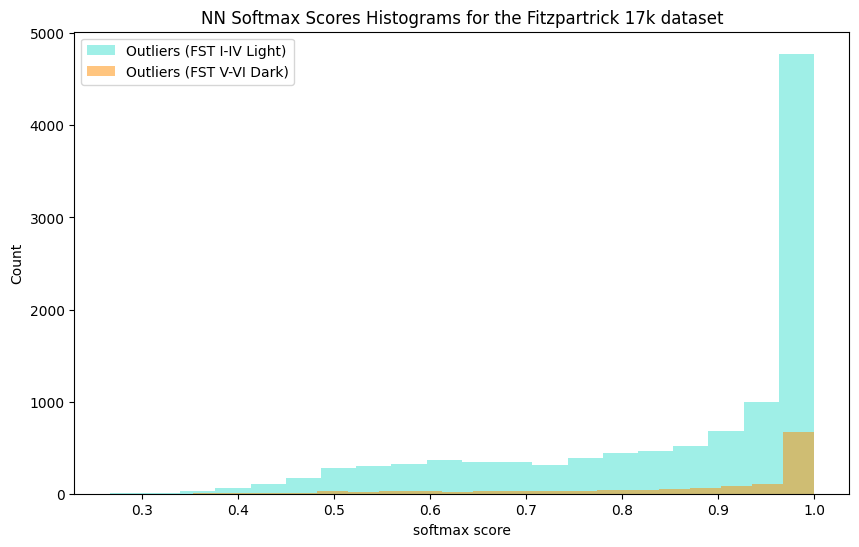

In [ ]:
from aux_vis import plot_Histogram

plot_Histogram(base_Lighter,base_Darker,'NN Softmax Scores Histograms for the Fitzpartrick 17k dataset','softmax score','Count')

### 4.4.2 Performance metrics calculation

In [ ]:
from sklearn.metrics import roc_curve, auc, f1_score
from aux_odin.py import calculate_metrics


### FST I-IV

In [ ]:
optimal_delta = 0.9962658286094666 #optimal theshold

# Load baseline scores
scores_in = np.loadtxt('densenet121_Base_In_Lighter_Only.txt')
scores_out = np.loadtxt('densenet121_Base_Out_Lighter_Only.txt')

calculate_metrics(scores_in, scores_out, optimal_delta)

Mean AUC: 0.8807, Mean F1 Score: 0.8506
Std Deviation of AUC: 0.0016, Std Deviation of F1 Score: 0.0000


### FST V-VI

In [ ]:
# Load baseline scores
scores_in = np.loadtxt('densenet121_Base_In_Darker_only.txt')
scores_out = np.loadtxt('densenet121_Base_Out_Darker_Only.txt')

calculate_metrics(scores_in, scores_out, optimal_delta)


Mean AUC: 0.8493, Mean F1 Score: 0.7484
Std Deviation of AUC: 0.0057, Std Deviation of F1 Score: 0.0000


### ALL

In [ ]:
# Load baseline scores
scores_in = np.loadtxt('densenet121_Base_In_ALL.txt')
scores_out = np.loadtxt('densenet121_Base_Out_ALL.txt')

calculate_metrics(scores_in, scores_out, optimal_delta)


Mean AUC: 0.8787, Mean F1 Score: 0.8468
Std Deviation of AUC: 0.0030, Std Deviation of F1 Score: 0.0000




---



## 4.5 ODIN

In [ ]:
in_dist_files_L = ['/content/densenet121_ODIN_200_0.0002_In_Lighter_Only.txt']
out_dist_files_L = ['/content/densenet121_ODIN_200_0.0002_Out_Lighter_Only.txt']
in_dist_files_D = ['/content/densenet121_ODIN_200_0.0002_In_Darker.txt']
out_dist_files_D = ['/content/densenet121_ODIN_200_0.0002_Out_Darker.txt']


in_dist_scores_L = pd.Series([float(score) for score in open(in_dist_files_L[0]).readlines()])
in_dist_scores_D = pd.Series([float(score) for score in open(in_dist_files_D[0]).readlines()])

out_dist_scores_L = pd.Series([float(score) for score in open(out_dist_files_L[0]).readlines()])
out_dist_scores_D = pd.Series([float(score) for score in open(out_dist_files_D[0]).readlines()])

# Create labels for each set of scores
in_dist_labels_L = pd.Series([0] * len(in_dist_scores_L))
in_dist_labels_D = pd.Series([1] * len(in_dist_scores_D))

out_dist_labels_L = pd.Series([2] * len(out_dist_scores_L))
out_dist_labels_D = pd.Series([3] * len(out_dist_scores_D))
# Concatenate scores and labels
in_dist_L_df = pd.concat([in_dist_scores_L, in_dist_labels_L], axis=1)
in_dist_L_df.columns = ['Scores', 'Labels']

in_dist_D_df = pd.concat([in_dist_scores_D, in_dist_labels_D], axis=1)
in_dist_D_df.columns = ['Scores', 'Labels']

out_dist_L_df = pd.concat([out_dist_scores_L, out_dist_labels_L], axis=1)
out_dist_L_df.columns = ['Scores', 'Labels']

out_dist_D_df = pd.concat([out_dist_scores_D, out_dist_labels_D], axis=1)
out_dist_D_df.columns = ['Scores', 'Labels']

df = pd.DataFrame({
    'Scores': pd.concat([in_dist_scores_L,in_dist_scores_D, out_dist_scores_L, out_dist_scores_D]),
    'Labels': pd.concat([in_dist_labels_L,in_dist_scores_D,out_dist_labels_L, out_dist_labels_D])
})

In [ ]:
out_dist_D_df["Labels"] = 3  # Assign label 3 to FST V-VI
out_dist_L_df["Labels"] = 2  # Assign label 2 to FST I-IV
in_dist_L_df["Labels"] = 0  # train data
in_dist_D_df["Labels"] = 1  #train data

# Concatenate the DataFrames into one
df = pd.concat([in_dist_L_df,in_dist_D_df, out_dist_L_df, out_dist_D_df], ignore_index=True)
df= df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Define the optimal threshold
optimal_threshold =  0.1799 
# Create the "Output" column based on the condition
df['Output'] = (df['Scores'] < optimal_threshold).astype(int)
df

,Scores,Labels,Output
0,0.176261,2,1
1,0.178890,2,1
2,0.175219,2,1
3,0.180510,2,0
4,0.176538,1,1
...,...,...,...
16544,0.177684,2,1
16545,0.174562,2,1
16546,0.198327,2,0
16547,0.177203,0,1


### 4.5.1 Histograms

In [ ]:
# Filter rows based on conditions
ODIN_Lighter = df[(df['Labels'] == 2) & (df['Output'] == 1) ]['Scores']
ODIN_Darker = df[(df['Labels'] == 3)& (df['Output'] == 1) ]['Scores']
ODIN_Inlier = df[(df['Labels'] == 0) &(df['Output'] == 0) ]['Scores']

# Print counts
print("Count of ODIN scores of lighter samples bellow threshold:", len(ODIN_Lighter))
print("Count of ODIN scores of darker samples bellow threshold:", len(ODIN_Darker))
print("Count of ODIN scores of inlier above threshold:", len(ODIN_Inlier))

Count of ODIN scores of lighter samples bellow threshold: 8580
Count of ODIN scores of darker samples bellow threshold: 957
Count of ODIN scores of inlier above threshold: 992


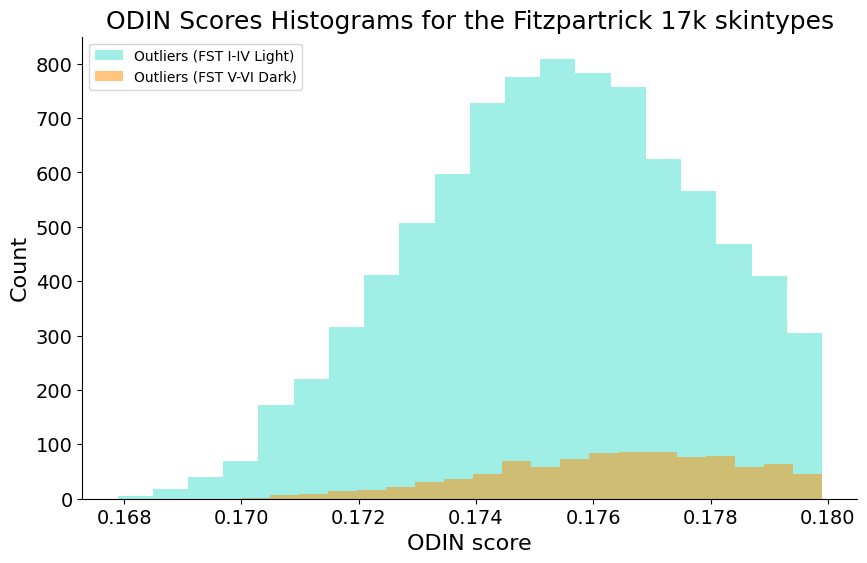

In [ ]:
from aux_vis import plot_Histogram

plot_Histogram(base_Lighter,base_Darker,'ODIN Scores Histograms for the Fitzpartrick 17k skintypes','ODIN score','Count')

### 4.5.2 Performance Metrics

In [ ]:
from sklearn.metrics import roc_curve, auc, f1_score
from aux_odin.py import calculate_metrics

### FST I-IV

In [ ]:
optimal_threshold = 0.1799 #define optimal threshold

scores_in = np.loadtxt('densenet121_ODIN_200_0.0002_In_Lighter_Only.txt')
scores_out= np.loadtxt('densenet121_ODIN_200_0.0002_Out_Lighter_Only.txt')

calculate_metrics(scores_in, scores_out, optimal_threshold)

Mean AUC: 0.6561, Mean F1 Score: 0.8914
Std Deviation of AUC: 0.0023, Std Deviation of F1 Score: 0.0000


### FST V-VI

In [ ]:
scores_in = np.loadtxt('densenet121_ODIN_200_0.0002_In_Darker.txt')
scores_out= np.loadtxt('densenet121_ODIN_200_0.0002_Out_Darker.txt')

calculate_metrics(scores_in, scores_out, optimal_threshold)

Mean AUC: 0.5574, Mean F1 Score: 0.5137
Std Deviation of AUC: 0.0061, Std Deviation of F1 Score: 0.0000


### ALL

In [ ]:
scores_in = np.loadtxt('densenet121_ODIN_200_0.0002_In_ALL.txt')
scores_out= np.loadtxt('densenet121_ODIN_200_0.0002_Out_ALL.txt')

calculate_metrics(scores_in, scores_out, optimal_threshold)

Mean AUC: 0.6505, Mean F1 Score: 0.9074
Std Deviation of AUC: 0.0051, Std Deviation of F1 Score: 0.0000
